# <center> NIRS <center> PREDICTION OF GROSS PROTEIN CONTENT IN THE DIET
***
# Table of Contents
* [READING THE DATASET INTO PYTHON](#READING-THE-DATASET-INTO-PYTHON)
* [DATA EDITING](#DATA-EDITING)
    * [Creating dummy variables (One-Hot Encode)](#Creating-dummy-variables-(One-Hot-Encode))
    * [Creating training and testing datasets](#Creating-training-and-testing-datasets)
***

In [39]:
from sys import stdout
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
df0 = pd.read_excel('Datasets/Lucas/dados_nirs_lucas.xlsx')
df = df0

In [41]:
#Reset
df = df0

# Transform all feautere names to string
df.columns = df.columns.map(str)

In [42]:
# Select all NIRS data as x
x = df.loc[:,'12493.238':'4007.556']

In [43]:
# Calculate second derivative
X2 = savgol_filter(x, 17, polyorder = 1,deriv=1)

In [44]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$T. de PB')
        plt.ylabel('Measured $^{\circ}$T. de PB')
 
        plt.show()
 
    return

In [45]:
x = pd.DataFrame(X2)

In [46]:
x.columns = df.loc[:,'12493.238':'4007.556'].columns

In [47]:
# Add Categoria feature
x = x.join(df.loc[:,['Status fisiologico', 'Categoria']])
x = pd.get_dummies(x, drop_first=False)

In [48]:
# Response variable vector
y = df['TD PB']

100% completed
Suggested number of components:  4



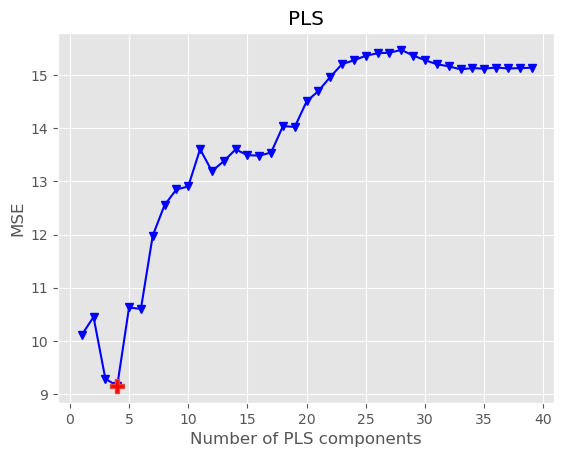

R2 calib: 0.590
R2 CV: 0.190
MSE calib: 4.629
MSE CV: 9.151


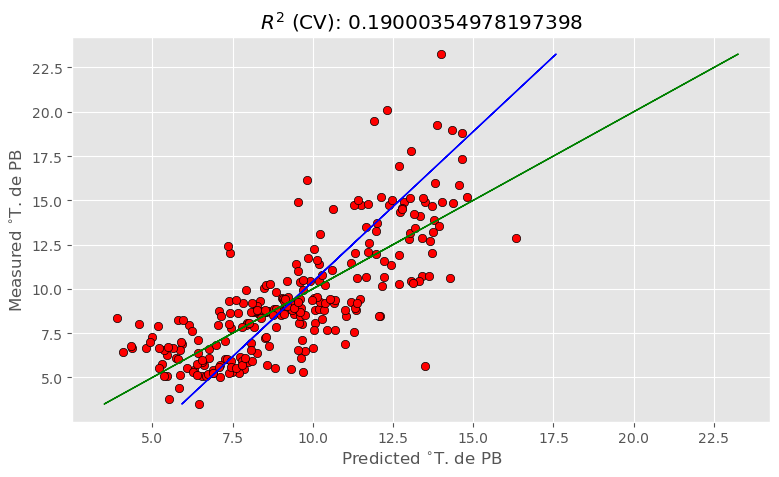

In [49]:
optimise_pls_cv(x,y, 40, plot_components=True)